https://minassaleh.github.io/

## Louisiana Hydrographic Data Analysis for Coastal Erosion Prevention
#### Mina Saleh and Ryan Park

### Project Description

There are a variety of strategies available for combating coastal erosion. One of the best protective elements for our coast is vegetation. In this notebook we will take a look at hydrographic measurements taken across Lousiana's coast in an effort to make a predictive classifier. This classifier will make a recomendation for a particular action to be taken for any given place across the coast. Extensive studies have been made to record hydrographic data in and near the coastal region of Lousiana. With access to data recorded by the Coastal Protection and Restoration Authority (CPRA), we can analyze some fundamental attributes pertaining to the vegetative conditions, namely the water level, the water's temperature, and the quality of the water by looking at the pH and salaninty. This data has been collected across a variety of research sites, with several years of recorded data for each. The data is available [here](https://cims.coastal.louisiana.gov/monitoring-data/).

## Table of Contents

1. [Packages and Requirements](#Packages)
2. [Data Extraction](#Extraction)
3. [Assembly and Tidying](#Tidy)
4. [Initial Exploratory Analysis](#Explore)
5. [Statistical Model](#Stat)
5. [Regression Model Prepartion](#Regr)
7. [Results](#Results)

### Project Plan (Disperse this info below in the future)

We already have a means of scraping the data sources provided by the CPRA. The next step is to isolate some relevant sites and make studies on them. At a foundational level, our program will record the desired hydrographic variables (water level, temperature, and quality) versus time. We can use visuals to survey various trends, and make more complex rate analysis later. For example, how is the rate of temperature change varying across a period of five years? Moreso, with the location of the measurement sites specified, we could link intresting results to local industrial endeavours. Furthermore, the CPRA has made signifcant endeavours to counter the threat of growing land erosion, available here: https://cims.coastal.louisiana.gov/outreach/projects/OPL_Full_page.html. With the data we have, we can attempt to understand the impact of each project. Ultimately, This project aims to use what we are learning throughout the class to provide an overview of the local water situation in the Lousiana area with the help of sensory data gathered by the CPRA. Our aim is to provide a more accessible overview of the fundamental data they have exracted, and then draw our own insight based on what we have. One possible goal of this project would be to make a recommendation to the local glass recycling organization, Glass Half Full Nola, who are interested in depositing recycled sand as a means to restore barrier islands that protect the mainland from storm surge and other storm related disasters. Where is the most useful place to deposit GHF sand? What size should the sand particles be? Are there places where it would be a bad idea to dump sand, and instead better to plant seeds?

In regards to our collaboration effort so far, we have already set up a private Github repository to update the code. We have met in person severals times to plan out and scope the project. Moving forward we will be meeting in person and on zoom to continuously update the project. 

The data below is monthly hydographic data recorded by the CPRA across a collection of sites, as part of various projects. The data contains various water attributes. For now, we will focus on temperature, elevation, pH, and salinity. The data was difficult to gather at first, since they are only accessible by submitting an e-mail request for each project. This was circumvented by using a bot. With the raw data extracted, the next step was to combine the project csv's into a single csv, and read that as a dataframe. This data frame was cleaned by removing extraneous attributes, replacing empty strings with NaNs, and combining the date and time.  

We have already isolated the table, which has an enormous collection of data, and cleaned it with what we currently intend to use. Moving forward, we will work on isolating several station ID's, and their associated data. We can then use the data we obtain from each station to understand the development of the water situation at that location.

<a name="Packages"></a>
### Packages and Requirements

In this notebook we will be using a variety of packages for our analysis, especially pandas and matplotlib. We will import all our requirements here.

In [3]:
import os
from os import listdir as ls
from os.path import join as pjoin
import re
import requests
import time
import geopandas as gpd
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.proxy import Proxy, ProxyType
from shapely.geometry import Point, Polygon

<a name="Extraction"></a>
### Data Extraction

First, we get the page information from the CPRA site. From these site objects, we can navigate the necessary downloads. There are three pages on the CPRA site that we are interested in, corresponding to vegetation, hydrographic data.

In [2]:
# Get information from CPRA coastal protection authority.
data_type = "biomass" # "hydro_monthly" "accretion"
site = f"https://cims.coastal.louisiana.gov/DataDownload/DataDownload.aspx?type={data_type}"
extract = requests.get(site)

In order to access CPRA data, we must submit download requests from the website as the data is not explicitly available from the site. One solution to this problem is to use a chromebot that will visit the CPRA site and execute the requests one at a time at a fast rate. There are roughly 500 downloads that we would like to extract across three datasets. For Mac, the following code requires the download of a [chrome driver](https://chromedriver.chromium.org/downloads) to be installed in ~/usr/bin/.

In [3]:
def chrome_bot(site, site_text, rotate_ip=False):
    email = "rpark1@tulane.edu"
    # Get the name of each project for field extract
    projects = re.findall("[A-Z]{2}-[0-9]{4}[\ -].*\)", site_text)
    # Optional start condition
    # projects = projects[projects.index("LA-0206 - HSDRRS ARMORING (10/20/2011 to 03/25/2021 [225])"):]
    # Start chrome bot.
    driver = webdriver.Chrome()
    for p in projects:
        # Go to CPRA.
        driver.get(site)
        # Check off for long/lat data
        driver.find_element_by_id("MainContent_CB_StationLatLong").click()
        # Select project.
        driver.find_element_by_id("MainContent_DDL_ProjectList").send_keys(p)
        # Press download
        driver.find_element_by_id("MainContent_BTN_DownLoad").click()
        try:
            # File small enough to auto extract.
            # Name the extract file
            driver.find_element_by_id("MainContent_TB_Filename").send_keys(p.split()[0])
            # Submit extraction 
            driver.find_element_by_id("MainContent_BTN_OkFilename").click()
        except Exception as e:
            # Otherwise must go through email.
            driver.find_element_by_id("MainContent_TB_OkCancelEmailInfo").send_keys(email)
            # Submit
            driver.find_element_by_id("MainContent_BTN_OkCancelEmailOk").click()
        # Close for next request.
        time.sleep(1.1)
    driver.close()

# Download each project found on the website locally, named into zip files after each project
# Note: some of these zip files are too big and get emailed to the email specified in chrome_bot
# chrome_bot(site, extract.text)

The code above takes about 20 minutes to download the each of the projects any of the website pages. Occasionally the bot will crash about half way through, in which case line 43 can be uncommented with the appropriate index query to start where the bot left off. An email must be supplied for files that are too large to download straight from the internet. The bot will have those files sent to the email specified in line 39. Once all emails are sent, files are downloaded from the email and then renamed to the project code prefix. Unzipping all the downloaded results in a set of csv files that are assembled into folders corresponding to each dataset.

<a name="Tidy"></a>
### Assembly and Tidying

After unzipping and renaming emailed files, we are left with csv files. We would like to combine these into pandas dataframes, and rewrite tidy data back to the disk for later loading. We can place data files from each page into three respective folders like so:
```
./data/
    |——CPRA_Hydro_Monthly/
    |——CPRA_Accretion/
    |——CPRA_Biomass/
```
in preparation for the combine step below

#### Combine Project Data

In [24]:
def combine_from_zip(name, blacklist=[]):
    """Concatonate csv files and create project column."""
    # My data location currently # TODO: decide on dir structure in github.
    df = pd.DataFrame()
    dat_path = pjoin("data", name)
    # data from storage.
    for f in ls(dat_path):
        # Skip non csv and blacklisted.
        if ".csv" not in f or f in blacklist:
            continue
        fpath = pjoin(dat_path, f)
        subdf = pd.read_csv(fpath, encoding="latin1")
        df = df.append(subdf)
    return df

hydro_untidy = combine_from_zip(r"C:\Users\Mina\Documents\GitHub\MinaSSaleh.github.io\CPRA_Hydro_Monthly\CPRA_Hydro_Monthly")
accretion_untidy = combine_from_zip(r"C:\Users\Mina\Documents\GitHub\MinaSSaleh.github.io\data\data\accretion.csv",
    blacklist=["BS-0019.csv", "BS-0026.csv", "BS-0008.csv", "BA-0158.csv", "BA-0159.csv"])
biomass_untidy = combine_from_zip(r"C:\Users\Mina\Documents\GitHub\MinaSSaleh.github.io\data\data\biomass.csv")
# Blacklisted data has an extra column, may optionally reformat those files.
# Assembling all data should take ~4 minutes.

C:\Users\Mina\AppData\Local\Temp/ipykernel_22388/1691335457.py:16: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  hydro_untidy = combine_from_zip(r"C:\Users\Mina\Documents\GitHub\MinaSSaleh.github.io\CPRA_Hydro_Monthly\CPRA_Hydro_Monthly")
C:\Users\Mina\AppData\Local\Temp/ipykernel_22388/1691335457.py:16: DtypeWarning: Columns (1,19,20,21,22,23,24,26,28,29,31,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  hydro_untidy = combine_from_zip(r"C:\Users\Mina\Documents\GitHub\MinaSSaleh.github.io\CPRA_Hydro_Monthly\CPRA_Hydro_Monthly")
C:\Users\Mina\AppData\Local\Temp/ipykernel_22388/1691335457.py:16: DtypeWarning: Columns (1,19,20,21,22,23,24,26,28,29,31,34) have mixed types.Specify dtype option on import or set low_memory=False.
  hydro_untidy = combine_from_zip(r"C:\Users\Mina\Documents\GitHub\MinaSSaleh.github.io\CPRA_Hydro_Monthly\CPRA_Hydro_Monthly")
C:\Users\Mina\AppData\Local\Temp/ipykernel_22388/

NotADirectoryError: [WinError 267] The directory name is invalid: 'C:\\Users\\Mina\\Documents\\GitHub\\MinaSSaleh.github.io\\data\\data\\accretion.csv'

#### Tidying Hydrographic Data

Some data like the comments, time zone, org name, and station ID aren't necessary for the present analysis, so we will leave them out. We would also like to convert all of the time data into datetime objects for easy time manipulation later.

In [21]:
# We can observe the columns
print(hydro_untidy.columns)
# Focus on only the columns we care about
col_drops = ["Velocity (ft/sec)", "Time Zone", "Comments",
             "Organization Name", "Original Collector Station ID"]
hydro_subset = hydro_untidy.drop(col_drops, axis=1)
# Rename some columns
hydro_subset = hydro_subset.rename(
    columns={"CPRA Station ID": "Station ID",
             "pH (pH units)": "pH"})
# Check timezone
# print(hydro["Time Zone"].unique()) # all CST

# Create pandas datetime columns
def convert_dt(df, prefix=""):
    """Takes in a DataFrame with Date and Time columns and replaces them with a Datetime column"""
    df.loc[:, "Datetime"] = pd.to_datetime(
        df[f"{prefix}Date (mm/dd/yyyy)"] + "_" + df[f"{prefix}Time (hh:mm)"],
        format="%m/%d/%Y_%H:%M")
    return df.drop([f"{prefix}Time (hh:mm)", f"{prefix}Date (mm/dd/yyyy)"], axis=1)

hydro = convert_dt(hydro_subset)
hydro.head()

Index(['CPRA Station ID', 'Original Collector Station ID', 'Date (mm/dd/yyyy)',
       'Time (hh:mm)', 'Time Zone', 'Staff Gauge (ft)', 'Geoid',
       'Station Depth (ft)', 'Measurement Depth (ft)',
       'Water Temperature (°C)', 'Specific Conductance (uS/cm)',
       'Salinity (ppt)', 'Dissolved Oxygen (mg/L)', 'pH (pH units)',
       'Velocity (ft/sec)', 'Soil Porewater Temperature (°C)',
       'Soil Porewater Specific Conductance (uS/cm)',
       'Soil Porewater Salinity (ppt)', 'Turbidity (FNU)',
       'Chlorophyll a (ug/L)', 'Total Nitrogen (mg/L)',
       'Total Kjeldahl Nitrogen (mg/L)', 'Nitrate as N (mg/L)',
       'Nitrite as N (mg/L)', 'Nitrate+Nitrite as N (unfiltered; mg/L)',
       'Nitrate+Nitrite as N (filtered; mg/L)',
       'Ammonium as N (unfiltered; mg/L)', 'Ammonium as N (filtered; mg/L)',
       'Total Phosphorus (mg/L)', 'Orthophosphate as P (unfiltered; mg/L)',
       'Orthophosphate as P (filtered; mg/L)', 'Silica (unfiltered; mg/L)',
       'Silica (filt

,Station ID,Staff Gauge (ft),Geoid,Station Depth (ft),Measurement Depth (ft),Water Temperature (°C),Specific Conductance (uS/cm),Salinity (ppt),Dissolved Oxygen (mg/L),pH,...,Orthophosphate as P (filtered; mg/L),Silica (unfiltered; mg/L),Silica (filtered; mg/L),Total Suspended Solids (mg/L),Volatile Suspended Solids (mg/L),Secchi (ft),Fecal Coliform (MPN/100ml),Latitude,Longitude,Datetime
0,CRMS6304-P01,0.67,NaN,NaN,0.328,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-10-19 10:40:00
1,CRMS6304-P01,2.28,NaN,NaN,0.328,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00
2,CRMS6304-P01,2.28,NaN,NaN,0.984,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00
3,CRMS6304-P01,1.28,NaN,NaN,0.328,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-12-28 12:31:00
4,CRMS6304-P01,1.28,NaN,NaN,0.984,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-12-28 12:31:00


#### Tidying Accretion Data
We can select the main accretion data of interest and average together the samples on the feldspare core. This will provide the estimate of soil accretion since establishment for the local station at each site. One issue with this dataset is that although the feature title indicates dates reported in (mm/dd/yyyy) format, some of the dates are in fact reported as (mm/dd/yy), so we must fix that before created datetime objects.

In [22]:
# Observe the dataset columns
print(accretion_untidy.columns)
# Focus on only the columns we care about
col_drops = ["Core Conditions", "Core X:Y", "Time Zone",
             "Organization", "Personnel", "Notes",
             "Unnamed: 18", "Group"]
acc_subset = accretion_untidy.drop(col_drops, axis=1)
# There are 3 invalid Lattitudes with notes instead of latt.
acc_subset = acc_subset[~acc_subset.Latitude.str.contains("per", na=False)]
# Inspect date formats.
# print(accretion_untidy["Sample Date (mm/dd/yyyy)"].value_counts())
# It appears that there are several dates given in a different format
def reformat_date(d):
    """Convert mm/dd/yy to mm/dd/yyyy"""
    sps = d.split("/")
    if len(sps[-1]) == 2:
        return "/".join(sps[:-1] + ["20"+sps[-1]])
    return d
# Reformat them here.
dcols = ["Sample Date (mm/dd/yyyy)", "Establishment Date (mm/dd/yyyy)"]
acc_subset[dcols[0]] = acc_subset[dcols[0]].map(reformat_date)
acc_subset[dcols[1]] = acc_subset[dcols[1]].map(reformat_date)

# Create an average accretion Measurement
acc_subset.loc[:, "Accretion (mm)"] = acc_subset[
    [f"Accretion Measurement {i} (mm)" for i in range(1,5)]].apply(np.mean, axis=1)
# Create datetime columns
accretion_ = convert_dt(acc_subset, prefix="Sample ")
accretion = convert_dt(accretion_, prefix="Establishment ")
accretion.head()

NameError: name 'accretion_untidy' is not defined

#### Tidying Biomass Data

Here we are interested in the density of vegetation in certain regions over time. We don't care as much about the scientific naming of plants or the height of the plants at the moment.

In [8]:
# Observe the dataset columns
print(biomass_untidy.columns)
# Focus on only the columns we care about
col_drops = ["Plot Size (m2)", "Scientific Name As Originally Observed",
             "Common Name As Originally Observed",
             "Standard Error Live Stem Diameter (mm)",
             "Standard Error Live Stem Height (cm)",
             "Scientific Name as Currently Recognized", "Comments", "Organization",
             "Personnel", "Live stems (N)"]
bio_subset = biomass_untidy.drop(col_drops, axis=1)
# Create datetime columns
bio_subset.loc[:, "Datetime"] = pd.to_datetime(bio_subset["Sample Date (mm/dd/yyyy)"], format="%m/%d/%Y")
biomass = bio_subset.drop("Sample Date (mm/dd/yyyy)", axis=1)
biomass.head()

Index(['Station ID', 'Sample Date (mm/dd/yyyy)', 'Plot Size (m2)',
       'Total Plot Aboveground Live Biomass (g/m2)',
       'Total Plot Aboveground Dead Biomass (g/m2)',
       'Scientific Name As Originally Observed',
       'Common Name As Originally Observed',
       'Scientific Name as Currently Recognized',
       'Common Name as Currently Recognized', 'Live stems (N)',
       'Average Live Stem Height (cm)', 'Standard Error Live Stem Height (cm)',
       'Average Live Stem Diameter (mm)',
       'Standard Error Live Stem Diameter (mm)',
       'Aboveground Live Biomass (g/m2)', 'Total Carbon (mg/g)',
       'Total Nitrogen (mg/g)', 'Total Phosphorus (mg/kg)', 'Organization',
       'Personnel', 'Comments', 'Latitude', 'Longitude'],
      dtype='object')


,Station ID,Total Plot Aboveground Live Biomass (g/m2),Total Plot Aboveground Dead Biomass (g/m2),Common Name as Currently Recognized,Average Live Stem Height (cm),Average Live Stem Diameter (mm),Aboveground Live Biomass (g/m2),Total Carbon (mg/g),Total Nitrogen (mg/g),Total Phosphorus (mg/kg),Latitude,Longitude,Datetime
0,CRMS0115-BAG01,1966.80,434.48,saltmeadow cordgrass,94.8,2.6,1712.20,455.73,15.24,1468.0,29.621697,-89.791252,2017-09-15
1,CRMS0115-BAG02,2268.36,713.80,saltmeadow cordgrass,161.4,4.2,2148.00,463.30,9.37,876.0,29.621815,-89.791259,2017-09-15
2,CRMS0115-BAG03,3894.88,937.76,saltmeadow cordgrass,125.7,4.0,3525.88,463.16,12.06,1038.0,29.622037,-89.791118,2017-09-15
3,CRMS0131-BAG01,1731.08,1033.68,saltmeadow cordgrass,116.7,2.4,1691.10,461.20,9.86,705.0,29.729517,-89.726266,2017-09-22
4,CRMS0131-BAG02,1218.80,657.60,saltmeadow cordgrass,102.6,3.0,1193.90,463.36,12.28,957.0,29.729675,-89.726447,2017-09-22


### Data Load Checkpoint

In [ ]:
# Save tidy data up to this point
write = False
if write:
    hydro.to_csv(pjoin("data", "hydro.csv"), index=False)
    accretion.to_csv(pjoin("data", "accretion.csv"), index=False)
    biomass.to_csv(pjoin("data", "biomass.csv"), index=False)

# Read in processed df from cells above
hydro = pd.read_csv(pjoin("data", "hydro.csv"))
accretion = pd.read_csv(pjoin("data", "accretion.csv"))
biomass = pd.read_csv(pjoin("data", "biomass.csv"))

# Recover datetimes
for df in [hydro, accretion, biomass]:
    df.loc[:, "Datetime"] = pd.to_datetime(df.Datetime)

### Exploratory Data Analysis

Now that we have the data we need, let's start investigating the structure and location of this data, starting out by plotting the data on a Lousisana state map using geopandas and the lattitude and longitude features of each set.

#### Site Locations
We will start by mapping out all of the sites on a map of Louisiana. We would like to see where all the unique sites are for each data set that we have assembled

In [5]:

hydro=pd.read_csv(r"C:\Users\Mina\Downloads\hydro.csv\hydro.csv",encoding= 'unicode_escape')
accretion=pd.read_csv(r"C:\Users\Mina\Downloads\CRMS_Biomass\CRMS_Biomass.csv",encoding= 'unicode_escape')
vegetation=pd.read_csv(r"C:\Users\Mina\Downloads\CRMS_Soil_Properties\CRMS_Soil_Properties.csv",encoding= 'unicode_escape')
biomass=pd.read_csv(r"C:\Users\Mina\Downloads\CRMS_Biomass\CRMS_Biomass.csv",encoding= 'unicode_escape')
hydro.head(10)
accretion.head(10)
vegetation.head(10)




,Station ID,Group,Sample Date (mm/dd/yyyy),Sample Depth (cm),Wet Soil pH (pH units),Dry Soil pH (pH units),Soil Specific Conductance (uS/cm),Soil Salinity (ppt),Soil Moisture Content (%),Bulk Density (g/cm3),...,Particle Size Mean (phi),Particle Size Median (phi),Particle Size Standard Deviation (phi),Radiometric Dating Method and Units,Isotope Concentration,Organization,Personnel,Comments,Latitude,Longitude
0,CRMS0002-S01,NaN,6/10/2008,0 to 4,6.11,5.48,2364.0,1.2,68.56,0.14,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
1,CRMS0002-S01,NaN,6/10/2008,4 to 8,5.71,4.39,1962.0,1.0,57.07,0.40,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
2,CRMS0002-S01,NaN,6/10/2008,8 to 12,5.42,4.50,2258.0,1.2,63.99,0.32,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
3,CRMS0002-S01,NaN,6/10/2008,12 to 16,5.90,5.07,3073.0,1.6,72.04,0.30,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
4,CRMS0002-S01,NaN,6/10/2008,16 to 20,6.45,5.37,3199.0,1.7,73.13,0.25,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
5,CRMS0002-S01,NaN,6/10/2008,20 to 24,6.88,5.83,3646.0,1.9,74.75,0.21,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
6,CRMS0002-S02,NaN,6/10/2008,0 to 4,6.21,4.76,2745.0,1.4,67.59,0.20,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100274,-89.791715
7,CRMS0002-S02,NaN,6/10/2008,4 to 8,6.81,4.00,3023.0,1.6,69.34,0.30,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100274,-89.791715
8,CRMS0002-S02,NaN,6/10/2008,8 to 12,6.86,5.19,3604.0,1.9,69.72,0.28,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100274,-89.791715
9,CRMS0002-S02,NaN,6/10/2008,12 to 16,6.74,5.17,4169.0,2.2,69.54,0.28,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100274,-89.791715


In [14]:
hydro.head(3)

,Unnamed: 0,Station ID,Measurement Depth (ft),Staff Gauge (ft),Water Temperature (Â°C),Specific Conductance (uS/cm),Salinity (ppt),pH (pH units),Latitude,Longitude,Datetime
0,0,CRMS6304-P01,0.328,0.67,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-10-19 10:40:00
1,1,CRMS6304-P01,0.328,2.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00
2,2,CRMS6304-P01,0.984,2.28,NaN,NaN,NaN,NaN,29.420313,-91.279049,2009-11-12 13:51:00


In [15]:
hydro.rename(columns={"CPRA Station ID": "Station ID"}, inplace=True)
accretion.head(5)

,Station ID,Sample Date (mm/dd/yyyy),Plot Size (m2),Total Plot Aboveground Live Biomass (g/m2),Total Plot Aboveground Dead Biomass (g/m2),Scientific Name As Originally Observed,Common Name As Originally Observed,Scientific Name as Currently Recognized,Common Name as Currently Recognized,Live stems (N),...,Standard Error Live Stem Diameter (mm),Aboveground Live Biomass (g/m2),Total Carbon (mg/g),Total Nitrogen (mg/g),Total Phosphorus (mg/kg),Organization,Personnel,Comments,Latitude,Longitude
0,CRMS0003-BAG01,9/15/2017,0.25,361.68,88.92,Spartina alterniflora Loisel.,smooth cordgrass,Spartina alterniflora Loisel.,smooth cordgrass,155.0,...,0.3,361.68,430.68,8.64,899.0,U.S. GEOL SURVEY (USGS),"Hamm, K",NaN,30.099428,-89.252902
1,CRMS0003-BAG02,9/15/2017,0.25,448.72,59.44,Spartina alterniflora Loisel.,smooth cordgrass,Spartina alterniflora Loisel.,smooth cordgrass,208.0,...,0.2,448.72,423.47,8.34,790.0,U.S. GEOL SURVEY (USGS),"Hamm, K",NaN,30.099302,-89.252896
2,CRMS0003-BAG03,9/15/2017,0.25,533.32,15.12,Spartina alterniflora Loisel.,smooth cordgrass,Spartina alterniflora Loisel.,smooth cordgrass,152.0,...,0.4,533.32,425.97,6.86,717.0,U.S. GEOL SURVEY (USGS),"Hamm, K",NaN,30.099279,-89.252731
3,CRMS0030-BAG01,8/15/2017,0.25,905.76,703.04,Spartina patens (Aiton) Muhl.,saltmeadow cordgrass,Spartina patens (Aiton) Muhl.,saltmeadow cordgrass,58.0,...,0.4,374.60,452.35,10.05,840.0,U.S. GEOL SURVEY (USGS),"Hamm, K",NaN,30.303690,-90.325453
4,CRMS0030-BAG01,8/15/2017,0.25,905.76,703.04,Sagittaria lancifolia L.,bulltongue arrowhead,Sagittaria lancifolia L.,bulltongue arrowhead,40.0,...,2.2,435.64,441.58,28.76,2213.0,U.S. GEOL SURVEY (USGS),"Hamm, K",NaN,30.303690,-90.325453


C:\ProgramData\Anaconda3\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:35: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
C:\ProgramData\Anaconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Co

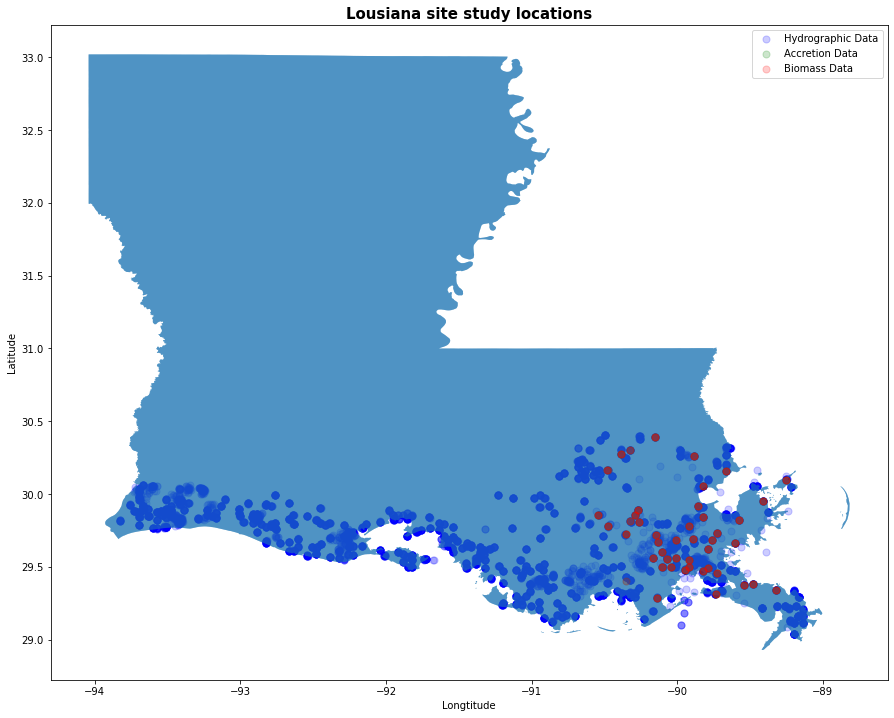

In [19]:
states = gpd.read_file(r"C:\Users\Mina\Documents\GitHub\MinaSSaleh.github.io\cb_2017_us_state_500k",)
def LA_plot(df, ax, title="", **plot_kw):
    """Scatter plot laid upon Louisiana using geopandas."""
    geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
    geo_df = gpd.GeoDataFrame(df, geometry=geometry)
    # Set graph features
    ax.set_xlabel("Longtitude")
    ax.set_ylabel("Latitude")
    states[states['NAME'] == 'Louisiana'].plot(ax=ax, alpha=0.4)
    geo_df.plot(ax=ax, **plot_kw)

# Create figure for LA
fig, ax = plt.subplots(figsize=(15,15))
# Plot location of sites from three datasets
for df, label, c in zip([hydro, accretion, biomass],
                        [f"{i} Data" for i in ["Hydrographic", "Accretion", "Biomass"]],
                        ["blue", "green", "red"]):
    LA_plot(df.groupby("Station ID").first(), ax, alpha=0.2, label=label, legend=True,
            markersize=50, c=c)

# Axes options
ax.set_title("Lousiana site study locations", fontsize=15, fontweight="bold");
ax.legend();

#### Hydrographic Variance
Since our project plans to recommend the best possible erosion protection strategy per water research site, we will start by looking at how varied the sites we are looking at actually are. 

We will first take a look at the staff gauge. Staff gauges signify how deep the water level at a particular site are. Having staff gauge data can be useful for identifying the water level development at a particular site. Additionally, as used below, examining the stagg gauge records can be useful for developing a preliminary idea on the uniformity of protection measures. 

In [40]:

vegetation.rename(columns={"Wet Soil pH (pH units)": "pH"}, inplace=True)
vegetation.rename(columns={"salinity": "Salinity"}, inplace=True)
vegetation.head(100)

,Station ID,Group,Sample Date (mm/dd/yyyy),Sample Depth (cm),pH,Dry Soil pH (pH units),Soil Specific Conductance (uS/cm),Salinity,Soil Moisture Content (%),Bulk Density (g/cm3),...,Particle Size Mean (phi),Particle Size Median (phi),Particle Size Standard Deviation (phi),Radiometric Dating Method and Units,Isotope Concentration,Organization,Personnel,Comments,Latitude,Longitude
0,CRMS0002-S01,NaN,6/10/2008,0 to 4,6.11,5.48,2364.0,1.2,68.56,0.14,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
1,CRMS0002-S01,NaN,6/10/2008,4 to 8,5.71,4.39,1962.0,1.0,57.07,0.40,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
2,CRMS0002-S01,NaN,6/10/2008,8 to 12,5.42,4.50,2258.0,1.2,63.99,0.32,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
3,CRMS0002-S01,NaN,6/10/2008,12 to 16,5.90,5.07,3073.0,1.6,72.04,0.30,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
4,CRMS0002-S01,NaN,6/10/2008,16 to 20,6.45,5.37,3199.0,1.7,73.13,0.25,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,CRMS0006-S03,NaN,6/20/2008,8 to 12,6.37,5.47,2305.0,1.2,79.28,0.24,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Lambou; D. Oehler,NaN,30.263589,-89.982076
96,CRMS0006-S03,NaN,6/20/2008,12 to 16,6.62,4.78,2191.0,1.1,83.71,0.15,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Lambou; D. Oehler,NaN,30.263589,-89.982076
97,CRMS0006-S03,NaN,6/20/2008,16 to 20,6.70,4.54,2106.0,1.1,87.70,0.12,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Lambou; D. Oehler,NaN,30.263589,-89.982076
98,CRMS0006-S03,NaN,6/20/2008,20 to 24,6.82,4.72,2101.0,1.1,85.27,0.14,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Lambou; D. Oehler,NaN,30.263589,-89.982076


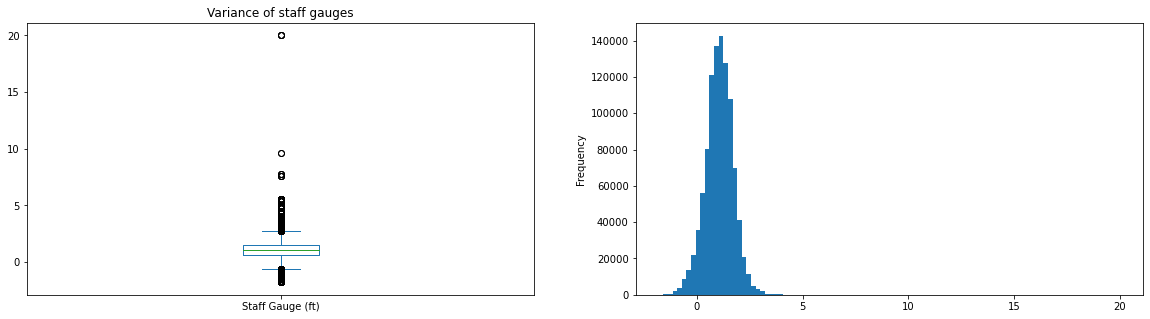

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
hydro["Staff Gauge (ft)"].plot.box(ax = ax[0], title="Variance of staff gauges")
hydro["Staff Gauge (ft)"].plot.hist(bins = 100);

Let's apply a similar sort of analysis to each of the pH and salinity. The water's pH will not necassarily make a difference in how suceptible an area is to flooding, or erosion, but can impact the choice of protection strategy. 

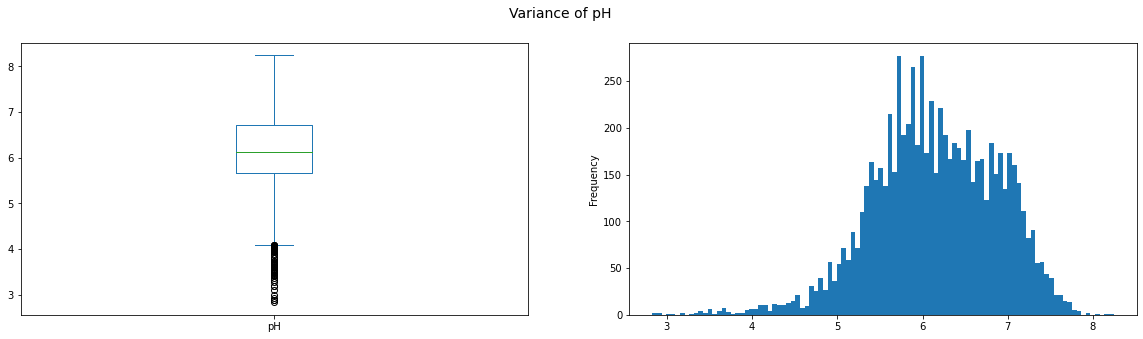

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
vegetation.pH.plot.box(ax = ax[0])
vegetation.pH.plot.hist(bins = 100);
fig.suptitle("Variance of pH", fontsize=14);

Here's another very similat test for salinity. We expect this may be another factor in the ability of a region to host vegetative growth after a long period of time.

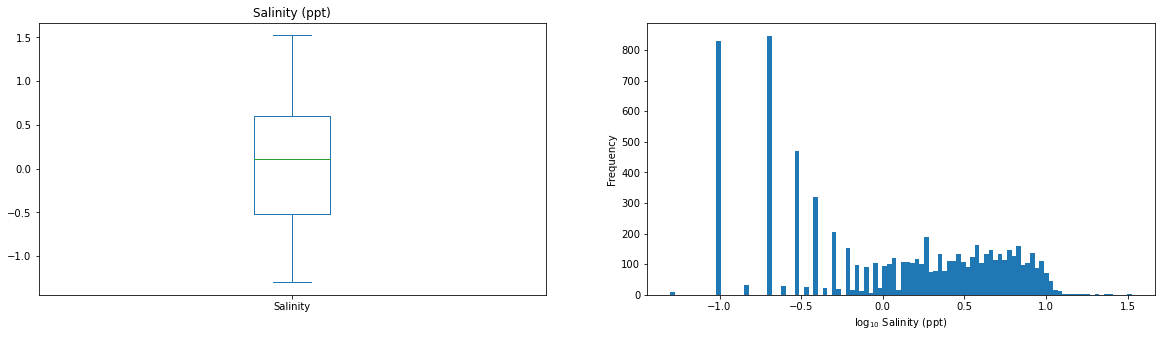

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
vegetation[vegetation["Salinity"] > 0]['Salinity'].map(np.log10).plot.box(ax = ax[0], title="Salinity (ppt)")
vegetation[vegetation["Salinity"] > 0]["Salinity"].map(np.log10).plot.hist(bins = 100)
ax[1].set_xlabel("log$_{10}$ Salinity (ppt)");

Here we observe the log transform of the data, lest we are unable to see the finer detail of all the data between 1e-3 and 1e4 ppt.

#### Vegetation Conditions

One of the most cost effective ways to mitigate the threat of erosion is through the effective use of vegetation. That's right, gardening can be as much a pastime as it could be a salvation effort for the effort. 

Plant roots can sturdy the structure of the sand, and reduce the risk of erosion. Plants typically thrive at PH between a PH of 5 and 7. None of our sites have that, but fortunately some varieties can grow at PH's as high as 8.5, which qualifies a good number of the sites, albeit tenuously. Let's take a look. 

In [83]:
unique_stations=(pd.unique(vegetation["Station ID"]))
pH_eligible=vegetation[(vegetation.pH<8.6)&(vegetation.pH>5)]
display(pH_eligible)
stations=pd.unique(vegetation["Station ID"])
pH_stations=pd.unique(pH_eligible["Station ID"])
print(len(pH_stations)/len(stations))

,Station ID,Group,Sample Date (mm/dd/yyyy),Sample Depth (cm),pH,Dry Soil pH (pH units),Soil Specific Conductance (uS/cm),Salinity,Soil Moisture Content (%),Bulk Density (g/cm3),...,Particle Size Mean (phi),Particle Size Median (phi),Particle Size Standard Deviation (phi),Radiometric Dating Method and Units,Isotope Concentration,Organization,Personnel,Comments,Latitude,Longitude
0,CRMS0002-S01,NaN,6/10/2008,0 to 4,6.11,5.48,2364.0,1.2,68.56,0.14,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
1,CRMS0002-S01,NaN,6/10/2008,4 to 8,5.71,4.39,1962.0,1.0,57.07,0.40,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
2,CRMS0002-S01,NaN,6/10/2008,8 to 12,5.42,4.50,2258.0,1.2,63.99,0.32,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
3,CRMS0002-S01,NaN,6/10/2008,12 to 16,5.90,5.07,3073.0,1.6,72.04,0.30,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
4,CRMS0002-S01,NaN,6/10/2008,16 to 20,6.45,5.37,3199.0,1.7,73.13,0.25,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,J. Beadle; J. Pace,NaN,30.100317,-89.791641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13650,CRMS6304-S03,NaN,4/23/2012,4 to 8,6.57,6.21,287.3,0.1,61.94,0.44,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,B. Lussier; K. Crochet,Abundant organic matter throughout each core; ...,29.470442,-91.199011
13651,CRMS6304-S03,NaN,4/23/2012,8 to 12,6.54,6.30,466.3,0.2,58.64,0.48,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,B. Lussier; K. Crochet,Abundant organic matter throughout each core; ...,29.470442,-91.199011
13652,CRMS6304-S03,NaN,4/23/2012,12 to 16,6.38,6.36,523.0,0.3,59.91,0.45,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,B. Lussier; K. Crochet,Abundant organic matter throughout each core; ...,29.470442,-91.199011
13653,CRMS6304-S03,NaN,4/23/2012,16 to 20,6.45,6.20,582.0,0.3,52.24,0.59,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,B. Lussier; K. Crochet,Abundant organic matter throughout each core; ...,29.470442,-91.199011


0.5311501597444089


About 53% of the stations were eligible. This is a very positive sign. 

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:35: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
C:\ProgramData\Anaconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


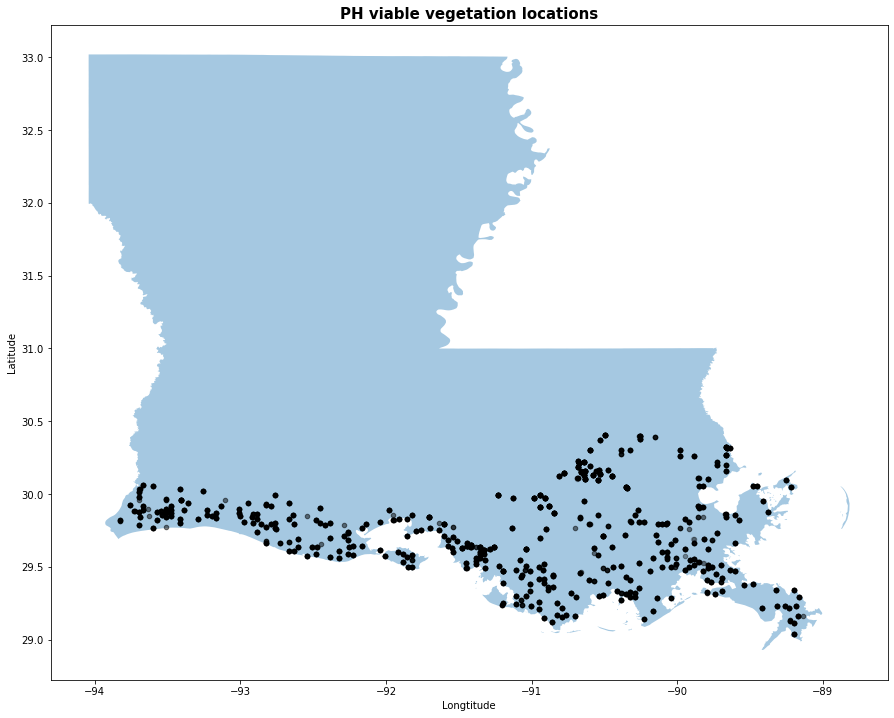

In [84]:
# Create axes for map object.
fig, ax = plt.subplots(figsize=(15, 15))
LA_plot(pH_eligible, ax, alpha=0.2, label=label, legend=True,
            markersize=20, c="black")
ax.set_title("PH viable vegetation locations", fontsize=15,fontweight="bold");

There were 12 unique sites,but only 4 points on the map. It could be surmised that these each sites had three recordings in approximately the same location, thereby overlapping on the map.
Here are the site recordings in dataframe form

In [18]:
display(pH_eligible)

,Station ID,Staff Gauge (ft),Geoid,Station Depth (ft),Measurement Depth (ft),Water Temperature (°C),Specific Conductance (uS/cm),Salinity (ppt),Dissolved Oxygen (mg/L),pH,...,Silica (unfiltered; mg/L),Silica (filtered; mg/L),Total Suspended Solids (mg/L),Volatile Suspended Solids (mg/L),Secchi (ft),Fecal Coliform (MPN/100ml),Latitude,Longitude,Datetime,geometry
641617,BA-WQ-TS1-01,NaN,NaN,22.96,1.640,29.5,40211.7,25.6,8.8,8.3,...,2.10,NaN,19.00,NaN,NaN,NaN,29.274000,-89.954500,2018-07-25 12:25:00,POINT (-89.95450 29.27400)
641618,BA-WQ-TS1-01,NaN,NaN,16.40,3.280,29.4,26066.0,15.9,5.9,8.5,...,2.60,NaN,27.00,NaN,NaN,NaN,29.274000,-89.954500,2018-09-26 09:53:00,POINT (-89.95450 29.27400)
641619,BA-WQ-TS1-01,NaN,NaN,19.68,1.640,19.1,16827.5,9.9,10.1,8.5,...,NaN,1.24,15.04,NaN,NaN,NaN,29.274000,-89.954500,2019-03-26 12:00:00,POINT (-89.95450 29.27400)
641620,BA-WQ-TS1-01,NaN,NaN,19.68,3.280,27.6,26890.4,11.8,7.5,8.5,...,NaN,0.91,49.34,NaN,NaN,NaN,29.274000,-89.954500,2019-05-21 11:48:00,POINT (-89.95450 29.27400)
641622,BA-WQ-TS1-01,NaN,NaN,26.24,3.280,30.9,29081.1,15.8,7.7,8.4,...,NaN,1.39,11.69,NaN,NaN,NaN,29.274000,-89.954500,2019-08-29 12:59:00,POINT (-89.95450 29.27400)
641623,BA-WQ-TS1-02,NaN,NaN,22.96,11.482,29.2,41955.6,24.9,7.1,8.2,...,2.10,NaN,28.00,NaN,NaN,NaN,29.274000,-89.954500,2018-07-25 12:19:00,POINT (-89.95450 29.27400)
641624,BA-WQ-TS1-02,NaN,NaN,16.40,8.202,29.4,26851.4,16.9,5.7,8.5,...,2.60,NaN,40.00,NaN,NaN,NaN,29.274000,-89.954500,2018-09-26 10:03:00,POINT (-89.95450 29.27400)
641625,BA-WQ-TS1-02,NaN,NaN,19.68,9.842,19.1,17044.2,10.1,9.9,8.5,...,NaN,1.23,21.49,NaN,NaN,NaN,29.274000,-89.954500,2019-03-26 11:45:00,POINT (-89.95450 29.27400)
641626,BA-WQ-TS1-02,NaN,NaN,19.68,9.842,27.3,23188.6,13.3,7.7,8.4,...,NaN,0.95,62.24,NaN,NaN,NaN,29.274000,-89.954500,2019-05-21 11:40:00,POINT (-89.95450 29.27400)
641628,BA-WQ-TS1-02,NaN,NaN,26.24,13.123,30.9,29529.1,16.1,7.6,8.4,...,NaN,1.52,12.29,NaN,NaN,NaN,29.274000,-89.954500,2019-08-29 12:49:00,POINT (-89.95450 29.27400)


After determining viable stations for growing vegetation, we can measure their "distance from an optimal location". For our purposes, this optimal location will have a pH of 6, and a salinity (how much salt is in the water) of zero. 

In [19]:
pH_d=pH_eligible[["Station ID","pH", "Salinity (ppt)"]]
pH_d = pH_d.append({"Station ID": "Placeholder", "pH":7,"Salinity (ppt)":0 }, ignore_index=True)
display(pH_d)

,Station ID,pH,Salinity (ppt)
0,BA-WQ-TS1-01,8.3,25.6
1,BA-WQ-TS1-01,8.5,15.9
2,BA-WQ-TS1-01,8.5,9.9
3,BA-WQ-TS1-01,8.5,11.8
4,BA-WQ-TS1-01,8.4,15.8
5,BA-WQ-TS1-02,8.2,24.9
6,BA-WQ-TS1-02,8.5,16.9
7,BA-WQ-TS1-02,8.5,10.1
8,BA-WQ-TS1-02,8.4,13.3
9,BA-WQ-TS1-02,8.4,16.1


You will notice that the each station has more than one measurement associated with, that's because these measurements were made over time. Let's take the average for each station. 

In [24]:
av_pH=pH_d.groupby("Station ID")["pH"].mean()
display(av_pH)
av_s=pH_d.groupby("Station ID")["Salinity (ppt)"].mean()
data ={"Station ID": pH_d["Station ID"], "Average pH": av_pH, "Average Silinity (ppt)": av_s}
updated_pH = pd.concat([av_pH, av_s],axis=1)
display(updated_pH)

Station ID
BA-WQ-TS1-01    8.440000
BA-WQ-TS1-02    8.400000
BA-WQ-TS1-03    8.400000
BA-WQ-TS2-01    8.400000
BA-WQ-TS2-02    8.425000
BA-WQ-TS2-03    8.380000
BA-WQ-TS4-01    8.400000
BA-WQ-TS4-02    8.150000
BA-WQ-TS4-03    8.000000
BA-WQ-TS6-01    8.300000
BA-WQ-TS6-02    8.160000
BA-WQ-TS6-03    8.116667
Placeholder     7.000000
Name: pH, dtype: float64

,pH,Salinity (ppt)
Station ID,,
BA-WQ-TS1-01,8.440000,15.800000
BA-WQ-TS1-02,8.400000,16.260000
BA-WQ-TS1-03,8.400000,17.160000
BA-WQ-TS2-01,8.400000,16.100000
BA-WQ-TS2-02,8.425000,16.650000
BA-WQ-TS2-03,8.380000,18.760000
BA-WQ-TS4-01,8.400000,20.833333
BA-WQ-TS4-02,8.150000,29.750000
BA-WQ-TS4-03,8.000000,32.800000


We finally have a table withthe average pH's and salinities for each site. Let's finally examine their distance from the Placeholder (the optimal location) after standerizing the above table.

In [27]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
updated_pH_std = (
    (updated_pH - updated_pH.mean()) / 
    updated_pH.std())

updated_pH_std['Distance from optimal'] = euclidean_distances(updated_pH_std, updated_pH_std.to_numpy()[12,None]).squeeze()
updated_pH_std.drop( index="Placeholder", inplace=True)
updated_pH_std = updated_pH_std.sort_values(by=['Distance from optimal'])
display(updated_pH_std)

,pH,Salinity (ppt),Distance from optimal
Station ID,,,
BA-WQ-TS2-01,0.521792,-0.510552,4.005475
BA-WQ-TS1-02,0.521792,-0.493371,4.012921
BA-WQ-TS1-03,0.521792,-0.396729,4.055903
BA-WQ-TS1-01,0.625026,-0.542766,4.085357
BA-WQ-TS2-02,0.586313,-0.451493,4.089247
BA-WQ-TS2-03,0.470175,-0.224920,4.091784
BA-WQ-TS6-01,0.263709,0.126571,4.105400
BA-WQ-TS4-01,0.521792,-0.002285,4.249655
BA-WQ-TS4-02,-0.123417,0.955189,4.360508


#### Availability of Hydrographic and Biomass Data

It seems that many some hydrographic variable such as the pH are only available at a select few sites. Let's see how many unique sites are available for each of our hydrographic variables.

In [29]:
# UNIFINISHED
# Merge hydrographic and vegetative on Station ID.

# hydro_bio = hydro.merge(biomass, how="inner", on=["Latitude", "Longitude"])
# print(hydro_bio.head())

# How many unique sites are there for each variable?
for feature, vals in hydro.iteritems():
    subna = hydro[hydro[feature].notna()]
    unique_sites = len(subna["Station ID"].unique())
    print(f"{feature:50} {unique_sites}")
    
# Especialls

Station ID                                         6752
Staff Gauge (ft)                                   5009
Geoid                                              4797
Station Depth (ft)                                 1079
Measurement Depth (ft)                             6728
Water Temperature (°C)                             1089
Specific Conductance (uS/cm)                       1025
Salinity (ppt)                                     1115
Dissolved Oxygen (mg/L)                            98
pH                                                 12
Soil Porewater Temperature (°C)                    6006
Soil Porewater Specific Conductance (uS/cm)        5980
Soil Porewater Salinity (ppt)                      6031
Turbidity (FNU)                                    75
Chlorophyll a (ug/L)                               71
Total Nitrogen (mg/L)                              71
Total Kjeldahl Nitrogen (mg/L)                     71
Nitrate as N (mg/L)                                23
Nitrit

In [30]:
# Are there any sites with measurements for every hydrographic variable?
non_hydrographic = ["Station ID", "Staff Gauge (ft)", "Station Depth (ft)",
                    "Measurement Depth (ft)", "Latitude", "Longitude", "Datetime"]
hg_vars = [k for k in hydro.columns if k not in non_hydrographic]
# There are not, what about subsets of variables?
display(hydro.dropna(subset=hg_vars[:4])[hg_vars[:4]])
display(hydro.dropna(subset=hg_vars[6:9])[hg_vars[6:9]])
# There seem to be some clusters of available interacting data here.

,Geoid,Water Temperature (°C),Specific Conductance (uS/cm),Salinity (ppt)
4037,GEOID12A,28.8,1822.0,0.9
4038,GEOID12A,28.7,1836.0,0.9
4058,GEOID12A,28.5,1799.0,0.9
4059,GEOID12A,28.5,1772.0,0.9
4069,GEOID12A,28.7,1841.0,0.9
...,...,...,...,...
1716306,GEOID12A,30.4,6125.0,3.3
1716307,GEOID12A,30.2,5999.0,3.0
1727662,GEOID12A,33.9,8547.0,4.7
1729022,GEOID12A,29.0,2036.0,1.1


,Soil Porewater Temperature (°C),Soil Porewater Specific Conductance (uS/cm),Soil Porewater Salinity (ppt)
0,19.6,1865.0,0.9
1,20.6,2343.0,1.2
2,20.0,3105.0,1.6
3,12.6,1931.0,1.0
4,14.4,3383.0,1.8
...,...,...,...
1746904,28.6,3130.0,1.6
1746905,28.7,3315.0,1.7
1746906,27.0,3524.0,1.8
1746908,30.2,3392.0,1.8


In [31]:
# UNFINISHED
# Which sites have the most hydropgraphic variables AND biomass density?

<a name="Stat"></a>
### Statistical Model

Let's do a time independent case study on a single site that has many of both biomass and hydrographic measurements. The goal is to to find pvalues for hydrographic variables that are correlated with biomass growth. This will inform our regression model on which variables to focus on, and which variables we can likely ignore.

### Regression Model

One of the best ways of combatting land erosion from wind and water is to plant vegetation near the coast. Plant roots spread through the sand making it more resilient against erosion, and above-ground vegitation encourages natural dune formation. Newly planted material often takes an entire season to establish itself and its protective effects are cumulative but slow. Sometimes it is necessary to take more immediate action into protecting the coast, such as the use of sandbags, man made dunes, or sea walls. Sea walls can often be difficult to maintain, as with sandbags, and these methods typically prevent futher vegitative growth in the area. Even man-made sand dunes lack the continuous density gradient that natural sands have which encourages plant-root growth. For these reasons we would like to use hydrographic, vegitation, and accretion data in order to classify regions of the coast as best being protected by one of the above methods.

To do this we will identify the hydrographic conditions that afford vegetative growth, search for locations that have little vegetation but the opportunity to grow more, and determine if active planting will be a good solution for that area. Alternatively, if the hydrographic conditions are not condusive to plant growth, we may classify that region as being best protected by unnatural sand formations.

As a secondary part of our model, we would like to use accretion data see how the coast is evolving overtime. If we could calculate how quickly the coastline is receeding in certain areas, then we could determine an "urgency" metric and rule out certain regions of the coast from viably being protected with plants. We may try to obtain population location data to try to determine weights to how urgent erosion prevention is in certain places across the coast.

### Plan

1. Build statistical model to obtain p-values for hydrographic features that are highly correlated with vegetation on the Louisiana Coast.
2. Select those features below a significant p threshold, and use them in a classification model
3. Interpolate hydrographic features to the geography.
    - Possibly use Gaussian Process Regression in order to obtain confidence intervals to address missing data         issues.
    - Alternatively, we could restrict our analysis to a smaller region with lots of significant variable data.
4. Partition the regions into areas with and without vegetative growth, then classify in regions without growth whether or not plants could grow there based on hydrgraphic similarity to vegetative regions.
5. Recession Rate
6. Economic factors

<a name="Res"></a>
### Results